In [5]:
# Preprocess and Explore the Data

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import os

plt.rcParams["figure.figsize"] = (12, 6)

ASSETS = ["TSLA", "BND", "SPY"]
START = "2015-07-01"
# Use end one day after so 2025-07-31 is included (yfinance end is exclusive in practice)
END = "2025-08-01"




def download_assets(tickers, start, end):
    """
    Download daily OHLCV data from yfinance and return dict of DataFrames.
    Uses 'Adj Close' for returns.
    """
    raw = yf.download(tickers, start=start, end=end, group_by="ticker", auto_adjust=False, threads=True)
    dfs = {}
    for t in tickers:
        if (t,) in raw.columns or isinstance(raw.columns, pd.MultiIndex):
            # MultiIndex returned when multiple tickers; handle accordingly
            df = raw[t].copy()
        else:
            # Single ticker returned as normal columns
            df = raw.copy()
        # ensure DatetimeIndex
        df.index = pd.to_datetime(df.index)
        dfs[t] = df
    return dfs


def clean_fill(df):
    """
    Basic cleaning:
     - Ensure numeric dtypes
     - Forward fill then linear interpolate prices if needed
     - Drop rows with all NaNs
    """
    df = df.copy()
    # Drop any rows where all columns are NaN
    df = df.dropna(how="all")
    # Cast numeric columns
    for col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    # First forward fill, then backward fill, then interpolate numeric columns
    df = df.ffill().bfill()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].interpolate(method="linear", limit_direction="both")
    return df


def compute_returns(df, price_col="Adj Close"):
    """
    Compute daily percentage returns based on adjusted close.
    """
    r = df[price_col].pct_change().rename("returns")
    return r


def rolling_stats(series, window=30):
    return series.rolling(window=window).mean(), series.rolling(window=window).std()


def detect_outliers(returns, z=3):
    """
    Detect days where returns exceed +/- z * std (using sample std).
    Return dataframe of outliers.
    """
    mu = returns.mean()
    sigma = returns.std()
    mask = (returns > mu + z * sigma) | (returns < mu - z * sigma)
    return returns[mask]


def adf_test(series, autolag="AIC"):
    """
    Run Augmented Dickey-Fuller test and return summary dict.
    """
    series = series.dropna()
    result = adfuller(series, autolag=autolag)
    out = {
        "adf_stat": result[0],
        "p_value": result[1],
        "used_lag": result[2],
        "n_obs": result[3],
        "crit_vals": result[4],
    }
    return out


def historical_var(returns, alpha=0.05):
    """
    Historical VaR for daily returns: the alpha quantile of losses.
    Note: returns assumed as decimal (e.g., 0.01 for 1%).
    Return negative VaR value meaning loss threshold (e.g., -0.03 means 3% loss).
    """
    if returns.dropna().empty:
        return np.nan
    # VaR at alpha is the left tail percentile
    var = np.percentile(returns.dropna(), 100 * alpha)
    return var


def sharpe_ratio(returns, risk_free_rate_annual=0.02, periods_per_year=252):
    """
    Annualized Sharpe Ratio (approx):
    SR = (mean_daily_return - rf_daily) / std_daily * sqrt(periods_per_year)
    """
    r = returns.dropna()
    if r.empty:
        return np.nan
    rf_daily = risk_free_rate_annual / periods_per_year
    excess_mean = r.mean() - rf_daily
    sr = (excess_mean / r.std()) * np.sqrt(periods_per_year)
    return sr


def summary_stats(returns):
    r = returns.dropna()
    return {
        "count": r.count(),
        "mean": r.mean(),
        "median": r.median(),
        "std": r.std(),
        "min": r.min(),
        "max": r.max(),
        "skew": r.skew(),
        "kurtosis": r.kurtosis(),
    }


def plot_series_price(df, ticker):
    plt.figure()
    plt.plot(df.index, df["Adj Close"], label=f"{ticker} Adj Close")
    plt.title(f"{ticker} Adj Close Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_returns(returns, ticker):
    plt.figure()
    plt.plot(returns.index, returns, label=f"{ticker} Daily Returns")
    plt.title(f"{ticker} Daily Returns")
    plt.xlabel("Date")
    plt.ylabel("Daily Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.hist(returns.dropna().values, bins=80, density=True)
    plt.title(f"{ticker} Daily Returns Distribution")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


def plot_rolling(returns, ticker, window=30):
    roll_mean, roll_std = rolling_stats(returns, window=window)
    plt.figure()
    plt.plot(returns.index, roll_mean, label=f"{ticker} {window}-day rolling mean")
    plt.plot(returns.index, roll_std, label=f"{ticker} {window}-day rolling std")
    plt.title(f"{ticker} Rolling Mean & STD ({window} day)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[*********************100%***********************]  3 of 3 completed

dict_keys(['TSLA', 'BND', 'SPY'])

Processing TSLA ...
Saved cleaned data to: ../data\TSLA_ohlcv.csv



C:\Users\bekuman\AppData\Local\Temp\ipykernel_13916\3596912697.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (t,) in raw.columns or isinstance(raw.columns, pd.MultiIndex):
C:\Users\bekuman\AppData\Local\Temp\ipykernel_13916\3596912697.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (t,) in raw.columns or isinstance(raw.columns, pd.MultiIndex):
C:\Users\bekuman\AppData\Local\Temp\ipykernel_13916\3596912697.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (t,) in raw.columns or isinstance(raw.columns, pd.MultiIndex):


--- TSLA Summary ---
Data points: 2536
Return summary:
  count: 2535
  mean: 0.0018140963851022338
  median: 0.001260661839917132
  std: 0.03728473695673184
  min: -0.21062824320390794
  max: 0.22689989839624536
  skew: 0.29556790224810225
  kurtosis: 4.3130457775550495
VaR 95% (daily): -0.0547, VaR 99% (daily): -0.0927
Annualized Sharpe Ratio (rf=2%): 0.7386
ADF price p-value: 0.5560
ADF returns p-value: 0.0000
Outlier days (returns beyond ±3σ): 41
Top positive outliers:
Date
2025-04-09    0.226900
2024-10-24    0.219190
2020-02-03    0.198949
2021-03-09    0.196412
2020-03-19    0.183877
Name: returns, dtype: float64
Top negative outliers:
Date
2020-09-08   -0.210628
2020-03-16   -0.185778
2020-02-05   -0.171758
2020-03-18   -0.160344
2025-03-10   -0.154262
Name: returns, dtype: float64


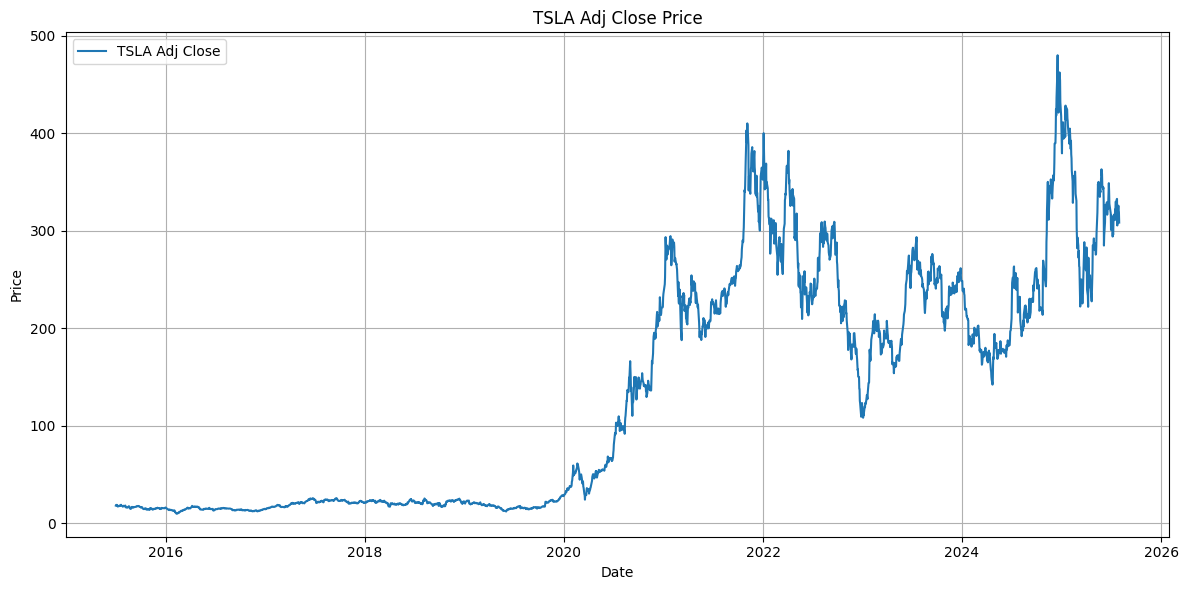

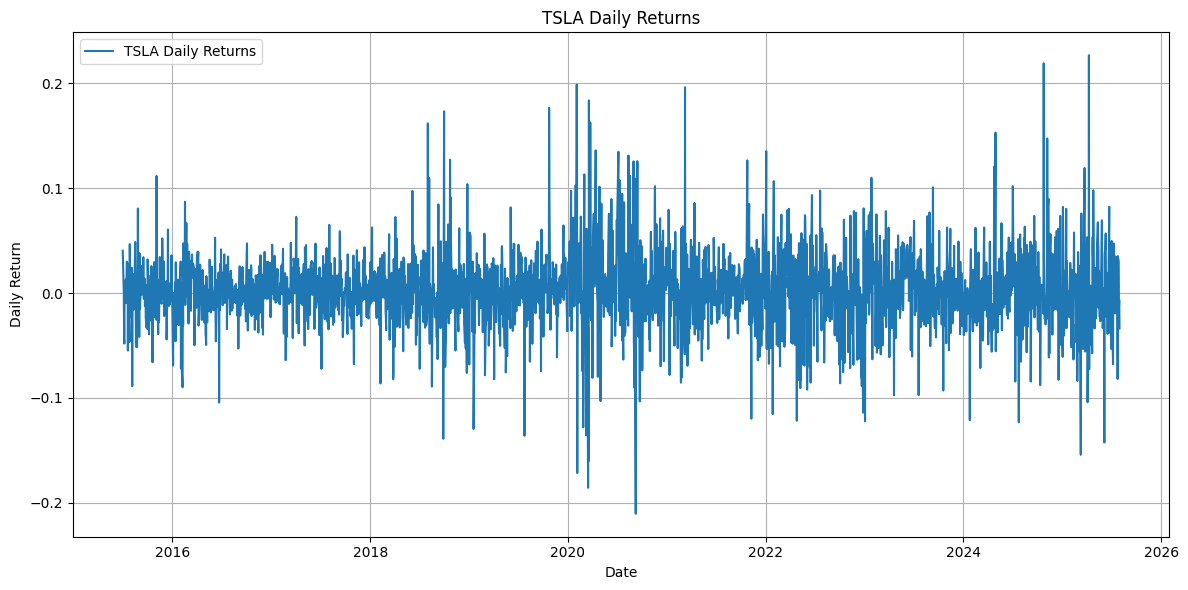

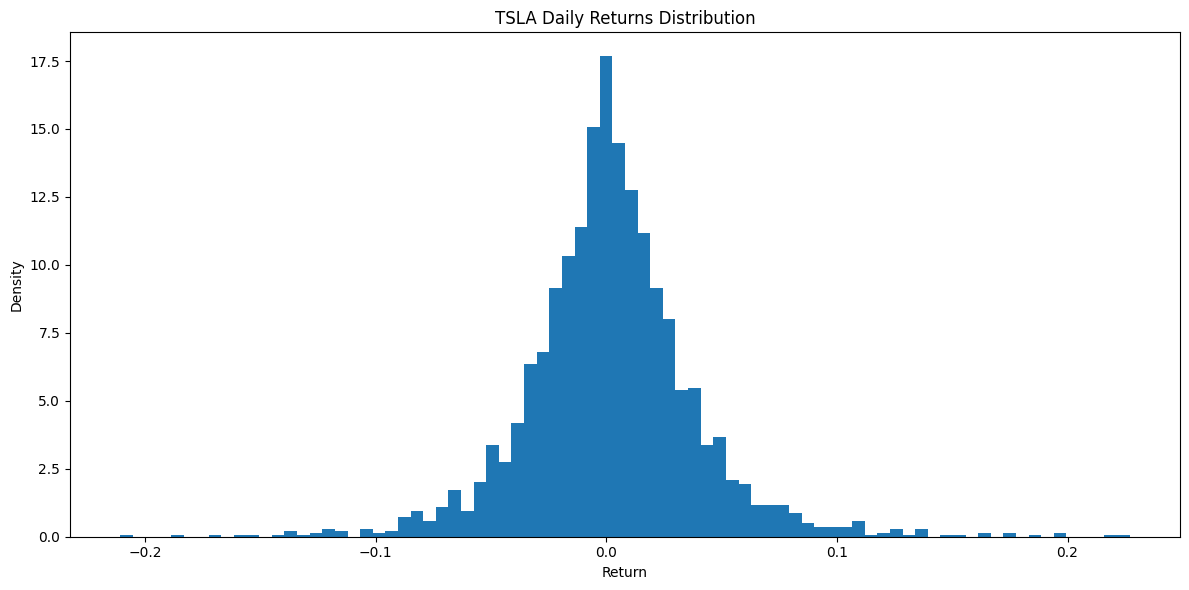

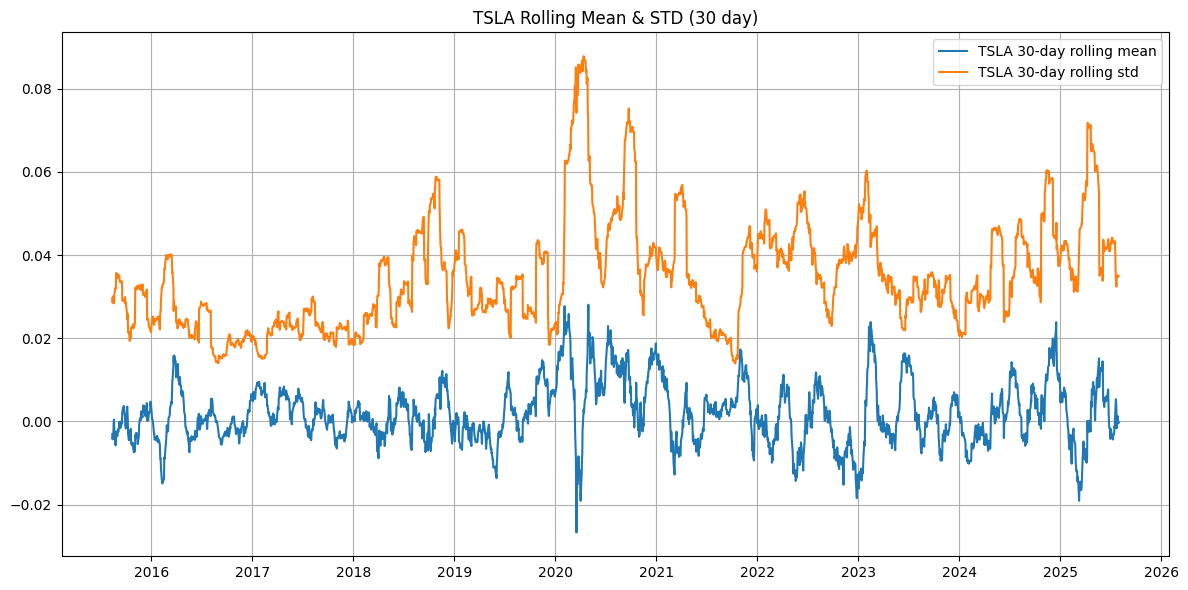


Processing BND ...
Saved cleaned data to: ../data\BND_ohlcv.csv
--- BND Summary ---
Data points: 2536
Return summary:
  count: 2535
  mean: 7.779831273359479e-05
  median: 0.0001270346448740689
  std: 0.0034588639839791798
  min: -0.05438525323566812
  max: 0.04220092003941578
  skew: -0.945012066291944
  kurtosis: 36.350864509318775
VaR 95% (daily): -0.0049, VaR 99% (daily): -0.0088
Annualized Sharpe Ratio (rf=2%): -0.0072
ADF price p-value: 0.5166
ADF returns p-value: 0.0000
Outlier days (returns beyond ±3σ): 26
Top positive outliers:
Date
2020-03-13    0.042201
2020-03-23    0.022149
2022-11-10    0.020702
2020-03-20    0.016955
2022-09-28    0.015543
Name: returns, dtype: float64
Top negative outliers:
Date
2020-03-12   -0.054385
2020-03-18   -0.024140
2020-03-17   -0.020686
2020-03-11   -0.018939
2022-06-13   -0.016152
Name: returns, dtype: float64


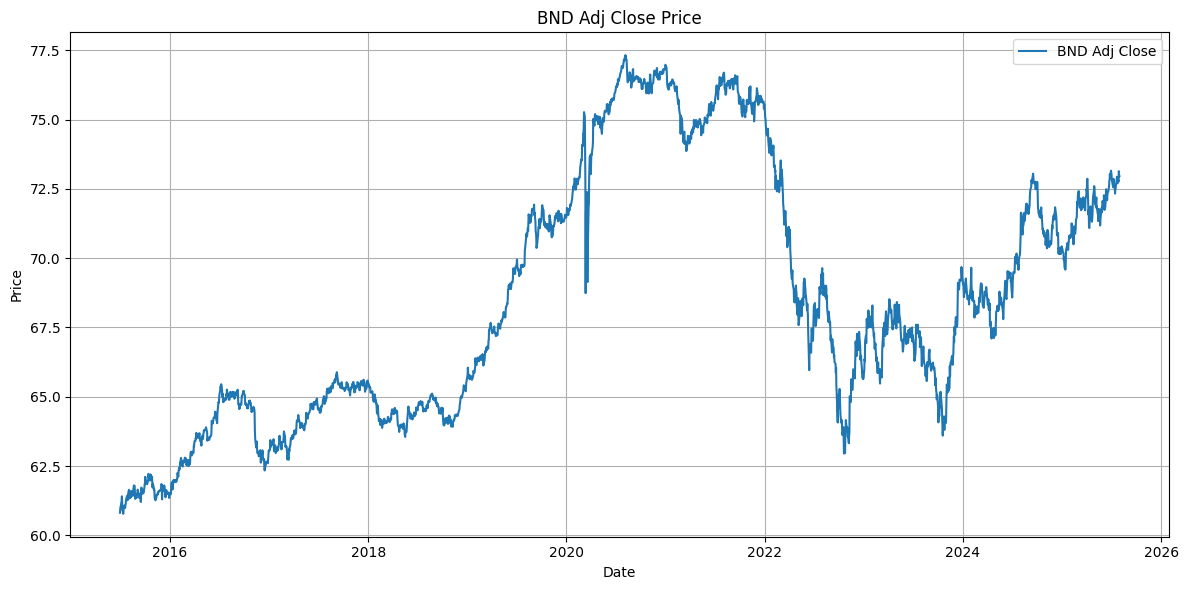

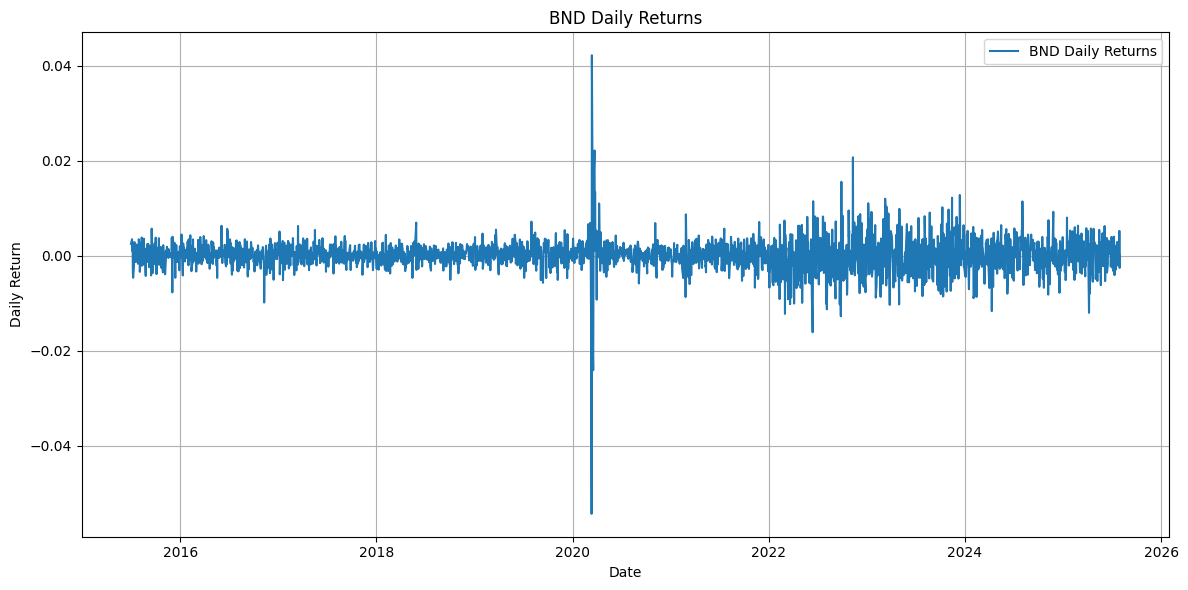

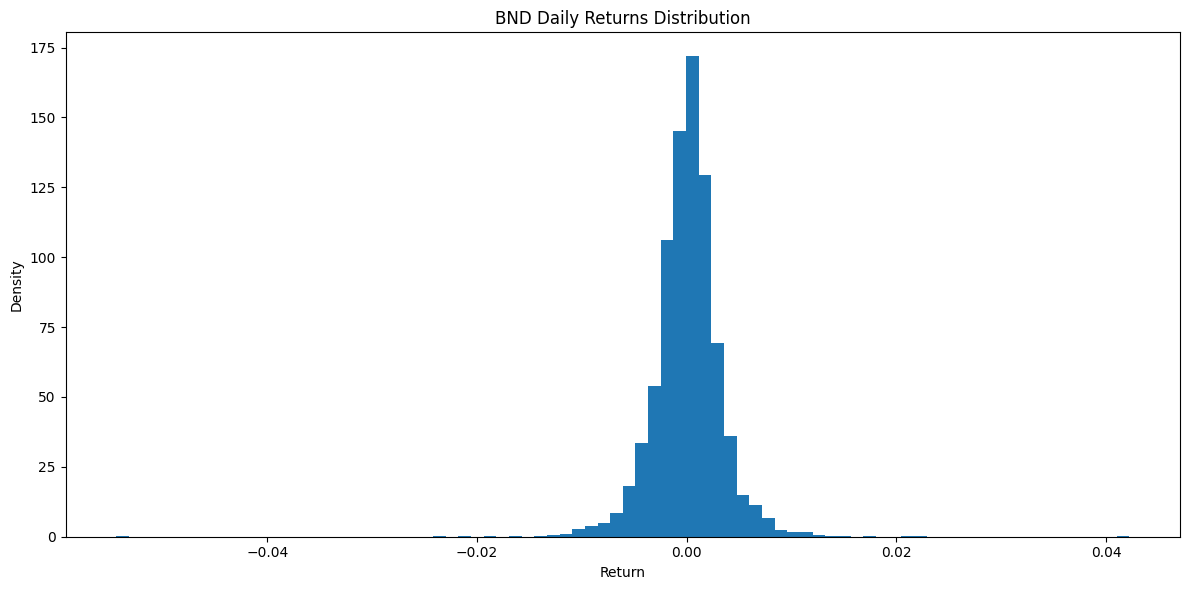

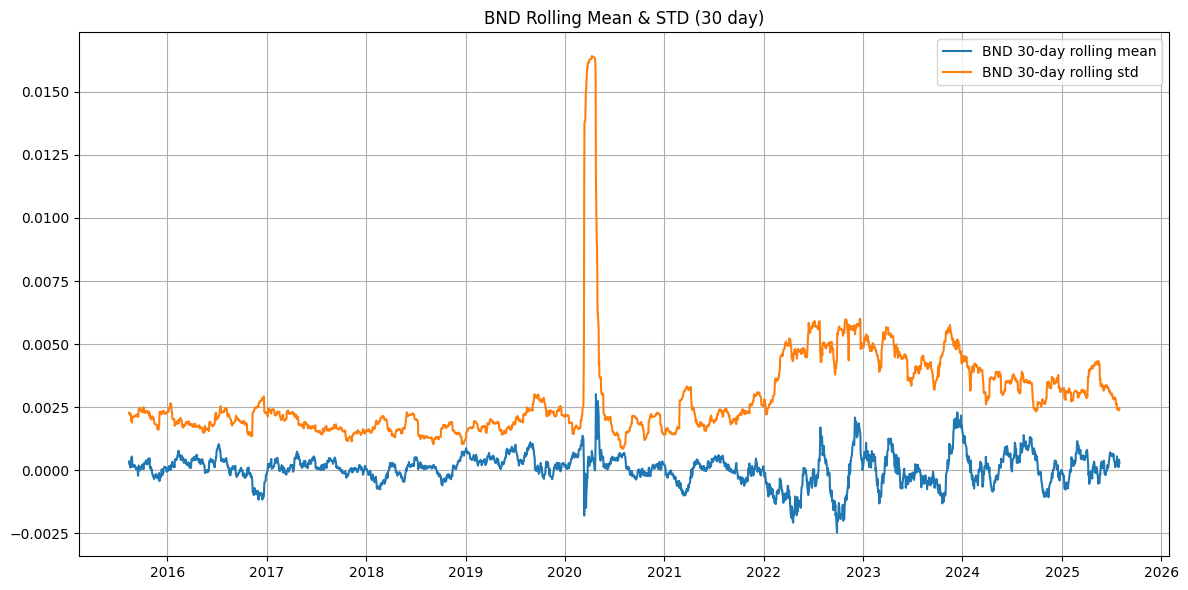


Processing SPY ...
Saved cleaned data to: ../data\SPY_ohlcv.csv
--- SPY Summary ---
Data points: 2536
Return summary:
  count: 2535
  mean: 0.0005730732044092424
  median: 0.0006373578920269019
  std: 0.011488624884112324
  min: -0.10942382187242017
  max: 0.10501936290804648
  skew: -0.30897671655997805
  kurtosis: 13.908355297650822
VaR 95% (daily): -0.0172, VaR 99% (daily): -0.0331
Annualized Sharpe Ratio (rf=2%): 0.6822
ADF price p-value: 0.9891
ADF returns p-value: 0.0000
Outlier days (returns beyond ±3σ): 35
Top positive outliers:
Date
2025-04-09    0.105019
2020-03-24    0.090603
2020-03-13    0.085486
2020-04-06    0.067166
2020-03-26    0.058390
Name: returns, dtype: float64
Top negative outliers:
Date
2020-03-16   -0.109424
2020-03-12   -0.095677
2020-03-09   -0.078095
2025-04-04   -0.058543
2020-06-11   -0.057649
Name: returns, dtype: float64


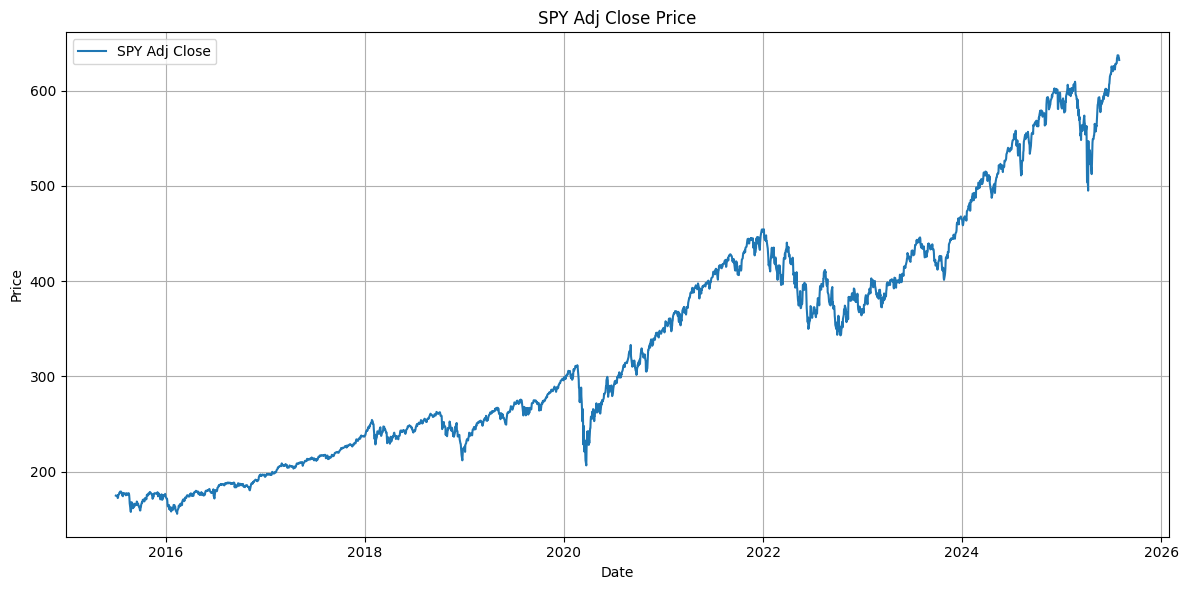

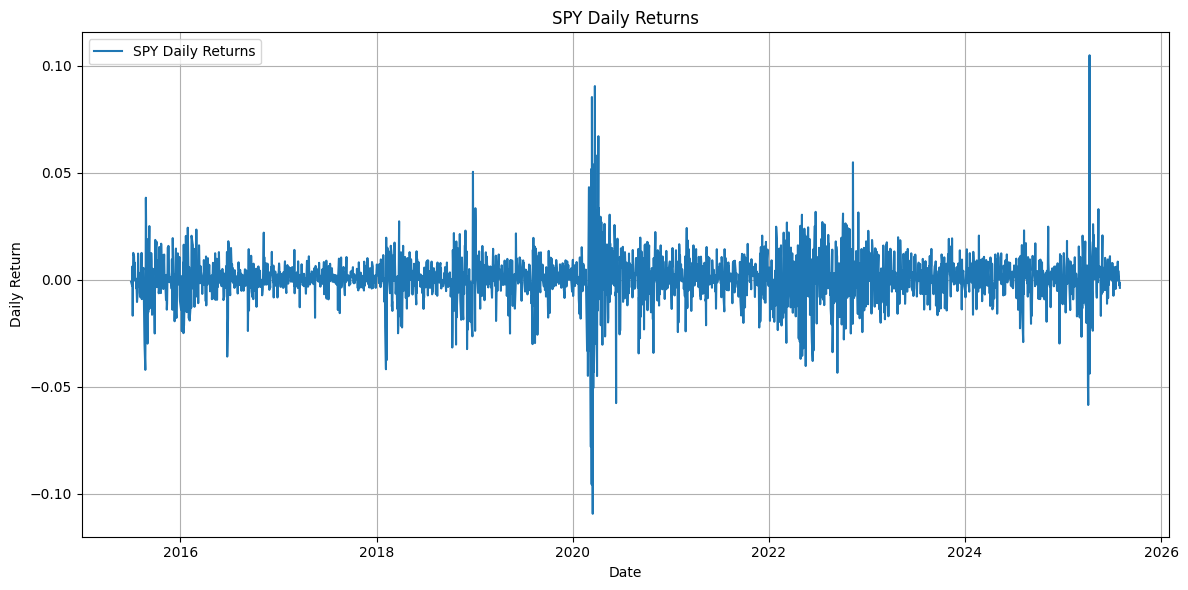

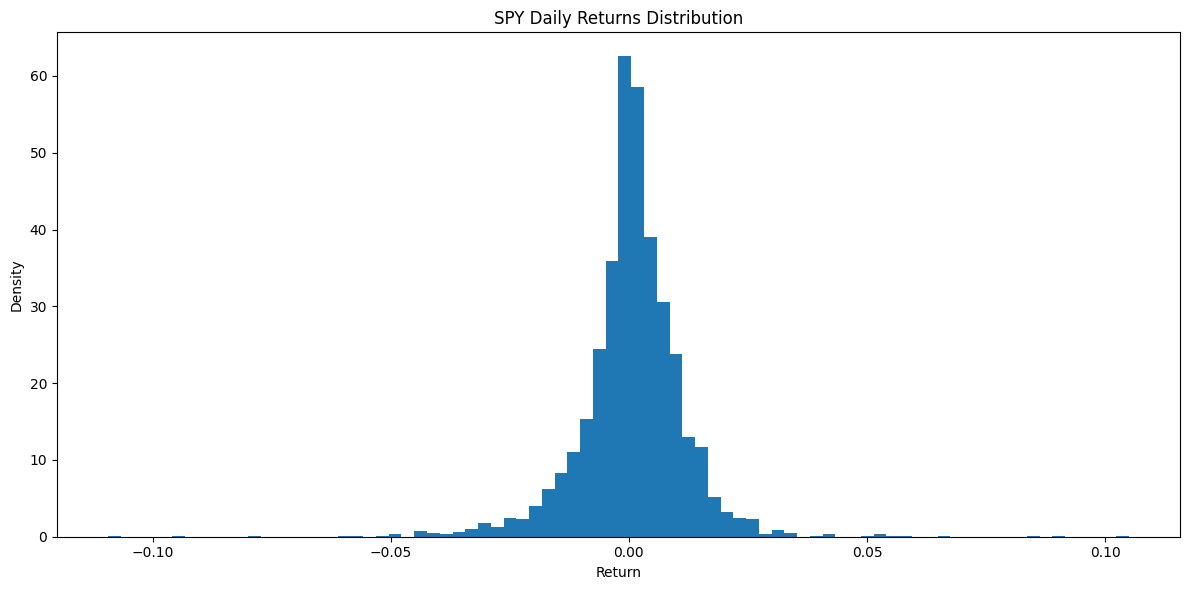

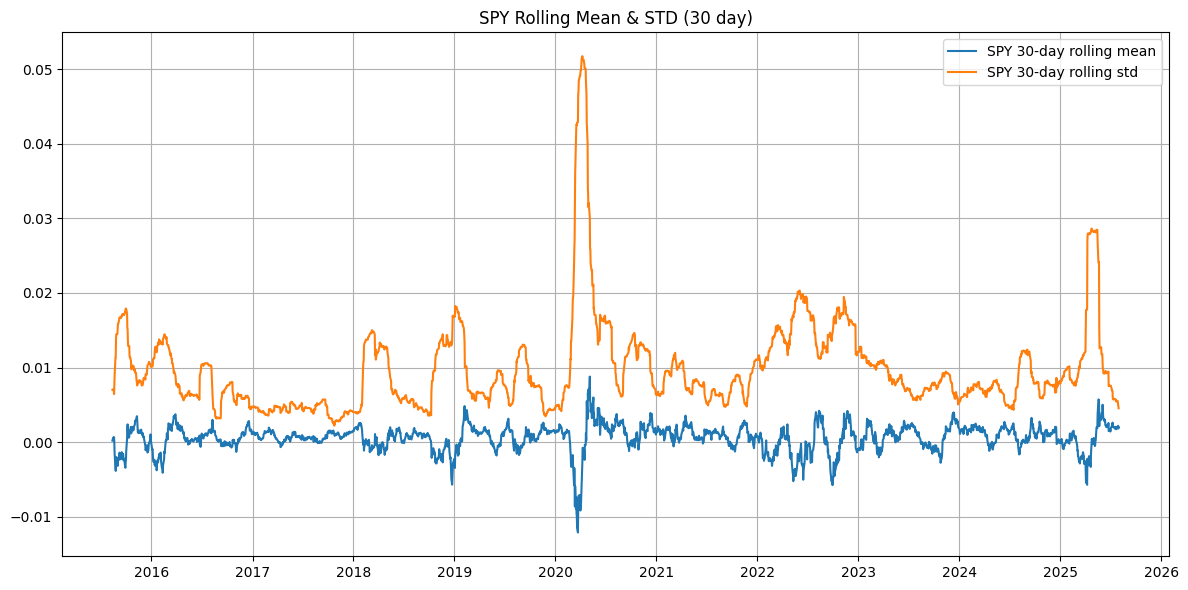

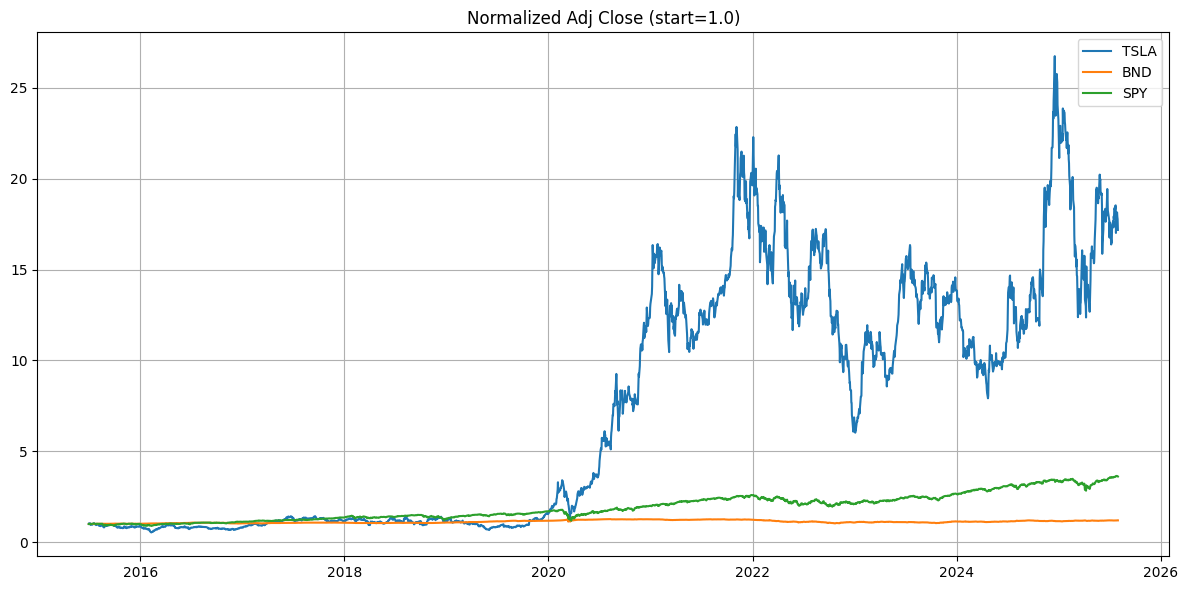


Task 1 completed. Processed results are returned as a dict .


In [13]:
dfs={}
def run_task1():
    print("Downloading data...")
    dfs = download_assets(ASSETS, START, END)
    processed = {}
    results = {}

    print(dfs.keys())

    for t, df in dfs.items():
        print(f"\nProcessing {t} ...")
        df_clean = clean_fill(df)
        # save raw CSV for reproducibility
        csv_path = os.path.join("../data", f"{t}_ohlcv.csv")
        df_clean.to_csv(csv_path)
        print(f"Saved cleaned data to: {csv_path}")
        

        returns = compute_returns(df_clean, price_col="Adj Close")
        outliers = detect_outliers(returns, z=3)

        # Rolling metrics
        roll_mean, roll_std = rolling_stats(returns, window=30)

        # ADF tests
        adf_price = adf_test(df_clean["Adj Close"])
        adf_returns = adf_test(returns)

        # Risk metrics
        var_95 = historical_var(returns, alpha=0.05)
        var_99 = historical_var(returns, alpha=0.01)
        sr = sharpe_ratio(returns, risk_free_rate_annual=0.02, periods_per_year=252)  # change rf as needed

        # Summary stats
        s_stats = summary_stats(returns)

        # Pack results
        res = {
            "df": df_clean,
            "returns": returns,
            "outliers": outliers,
            "roll_mean_30": roll_mean,
            "roll_std_30": roll_std,
            "adf_price": adf_price,
            "adf_returns": adf_returns,
            "var_95": var_95,
            "var_99": var_99,
            "sharpe": sr,
            "summary_stats": s_stats,
        }
        processed[t] = res

        # Print concise report for this asset
        print(f"--- {t} Summary ---")
        print(f"Data points: {len(df_clean)}")
        print("Return summary:")
        for k, v in s_stats.items():
            print(f"  {k}: {v}")
        print(f"VaR 95% (daily): {var_95:.4f}, VaR 99% (daily): {var_99:.4f}")
        print(f"Annualized Sharpe Ratio (rf=2%): {sr:.4f}")
        print(f"ADF price p-value: {adf_price['p_value']:.4f}")
        print(f"ADF returns p-value: {adf_returns['p_value']:.4f}")
        print(f"Outlier days (returns beyond ±3σ): {len(outliers)}")
        # show top positive and negative outliers
        if not outliers.empty:
            top_pos = outliers.sort_values(ascending=False).head(5)
            top_neg = outliers.sort_values().head(5)
            print("Top positive outliers:")
            print(top_pos)
            print("Top negative outliers:")
            print(top_neg)

        # Quick plots (show)
        plot_series_price(df_clean, t)
        plot_returns(returns, t)
        plot_rolling(returns, t, window=30)

    # cross-asset quick comparison plot: Adj Close normalized
    plt.figure()
    for t, res in processed.items():
        s = res["df"]["Adj Close"]
        norm = s / s.iloc[0]
        plt.plot(norm.index, norm, label=t)
    plt.title("Normalized Adj Close (start=1.0)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

   

    return processed

    
processed_results = run_task1()
print("\nTask 1 completed. Processed results are returned as a dict .")